In [192]:
import numpy as np          
import pandas as pd        
import scipy as sp          
import scipy.stats as stats
import scipy.optimize as op
import scipy.signal as sig
import statistics as stat
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob           

from scipy.stats import gaussian_kde
from numpy import mean
from statistics import stdev
from numpy.fft import rfft, rfftfreq

import time
import sys
import math
import struct
%matplotlib inline

In [193]:
#
# how to run this
#this analysis is done for janurary data 2015 at apachipoint
#1: you will need the level 1 files in min: you can find it in ap046 > level1 > 2015, the GGP fils in there are in min
#you will need to download it, open it, open the file as txt and save it as txt. 
#2: you will need to load them at the locations shown below, and everything should be done.
#
#wher to find the calibration number to convert V to nms^-2
#you will need to go to ap046 > level 1 folder, there are two calibration files in that folder along with 2009-2018 data folders
#in the file IGETS-SG-CAL-ap046-20210300.cal, you can find the gcal value of -944.3833 on the last row, which was applied since 20130908, that is the one we are using.

In [ ]:

## Change all gpp into txt if needed!!

# directory path
#path = r'C:\Users\gxy_0\Schiltach\bf056-1\Level3\2015'

# get all .gpp files
#gpp_files = glob.glob(os.path.join(path, '*.ggp'))

# rename each file
#for gpp_file in gpp_files:
    # generate new file name
    #new_file = os.path.splitext(gpp_file)[0] + '.txt'
    
    # rename file
    #os.rename(gpp_file, new_file)

In [194]:
file_pattern = r"C:\Users\gxy_0\Schiltach\bf056-1\Level3\2015\*.txt"
file_paths = glob.glob(file_pattern)

lev3_list = []
for file_path in file_paths:
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=19, names=["yyyymmdd", "hhmmss", "res_fil", "res_nofil", "tides", "rotation", "atm_load", "drift", "g_fil", "p_fil"])
    lev3_list.append(df)

# Concatenate all DataFrames into a single DataFrame
lev3 = pd.concat(lev3_list, ignore_index=True)
lev3

,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil
0,20120101,100.0,-11.525,-11.525,-122.829,2.916,2.880,-86.202,-214.760,-0.562
1,20120101,200.0,-11.496,-11.496,-123.032,2.916,2.828,-86.202,-214.987,-0.542
2,20120101,300.0,-11.476,-11.476,-123.240,2.915,2.829,-86.202,-215.174,-0.546
3,20120101,400.0,-11.470,-11.470,-123.452,2.915,2.854,-86.202,-215.355,-0.561
4,20120101,500.0,-11.470,-11.470,-123.668,2.915,2.889,-86.202,-215.536,-0.580
...,...,...,...,...,...,...,...,...,...,...
4207771,20191231,235700.0,9.739,9.739,-461.404,-5.963,-44.365,-99.638,-601.631,14.405
4207772,20191231,235800.0,9.772,9.772,-464.463,-5.964,-44.355,-99.638,-604.647,14.404
4207773,20191231,235900.0,9.757,9.757,-467.513,-5.964,-44.327,-99.638,-607.685,14.395
4207774,88888888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
df_bad_3 = lev3.loc[(lev3["p_fil"] == 'nan')| (lev3["g_fil"] == 'nan') | (lev3["hhmmss"] == 'nan')| (lev3["yyyymmdd"] == 99999999)| (lev3["yyyymmdd"] == 88888888) ]#find bad column
bad_index_3 = df_bad_3.index.tolist()#make them into list
lev3 = lev3.drop(lev3.index[bad_index_3])#remove bad rows
lev3 = lev3.reset_index()
lev3

,index,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil
0,0,20120101,100.0,-11.525,-11.525,-122.829,2.916,2.880,-86.202,-214.760,-0.562
1,1,20120101,200.0,-11.496,-11.496,-123.032,2.916,2.828,-86.202,-214.987,-0.542
2,2,20120101,300.0,-11.476,-11.476,-123.240,2.915,2.829,-86.202,-215.174,-0.546
3,3,20120101,400.0,-11.470,-11.470,-123.452,2.915,2.854,-86.202,-215.355,-0.561
4,4,20120101,500.0,-11.470,-11.470,-123.668,2.915,2.889,-86.202,-215.536,-0.580
...,...,...,...,...,...,...,...,...,...,...,...
4207579,4207769,20191231,235500.0,9.792,9.792,-455.257,-5.963,-44.411,-99.638,-595.477,14.419
4207580,4207770,20191231,235600.0,9.746,9.746,-458.336,-5.963,-44.377,-99.638,-598.568,14.407
4207581,4207771,20191231,235700.0,9.739,9.739,-461.404,-5.963,-44.365,-99.638,-601.631,14.405
4207582,4207772,20191231,235800.0,9.772,9.772,-464.463,-5.964,-44.355,-99.638,-604.647,14.404


In [196]:
print (lev3["hhmmss"])

0             100.0
1             200.0
2             300.0
3             400.0
4             500.0
             ...   
4207579    235500.0
4207580    235600.0
4207581    235700.0
4207582    235800.0
4207583    235900.0
Name: hhmmss, Length: 4207584, dtype: float64


In [197]:
# Assuming 'lev3' is your DataFrame

# Split 'hhmmss' column into separate components
lev3['hours'] = lev3['hhmmss'] // 10000
lev3['minutes'] = (lev3['hhmmss'] // 100) % 100
lev3['seconds'] = lev3['hhmmss'] % 100

# Calculate total minutes
lev3['minutes_only'] = lev3['hours'] * 60 + lev3['minutes']

print(lev3['minutes_only'])

0             1.0
1             2.0
2             3.0
3             4.0
4             5.0
            ...  
4207579    1435.0
4207580    1436.0
4207581    1437.0
4207582    1438.0
4207583    1439.0
Name: minutes_only, Length: 4207584, dtype: float64


In [198]:
# Assuming 'lev3' is your DataFrame

# Convert 'yyyymmdd' column to datetime format
lev3['date'] = pd.to_datetime(lev3['yyyymmdd'], format='%Y%m%d')

# Define the starting date
starting_date = pd.to_datetime('20150101', format='%Y%m%d')

# Calculate the timedelta from the starting date
lev3['elapsed_minutes'] = (lev3['date'] - starting_date).dt.total_seconds() // 60

print(lev3['elapsed_minutes'])

0         -1578240.0
1         -1578240.0
2         -1578240.0
3         -1578240.0
4         -1578240.0
             ...    
4207579    2628000.0
4207580    2628000.0
4207581    2628000.0
4207582    2628000.0
4207583    2628000.0
Name: elapsed_minutes, Length: 4207584, dtype: float64


In [199]:
lev3

,index,yyyymmdd,hhmmss,res_fil,res_nofil,tides,rotation,atm_load,drift,g_fil,p_fil,hours,minutes,seconds,minutes_only,date,elapsed_minutes
0,0,20120101,100.0,-11.525,-11.525,-122.829,2.916,2.880,-86.202,-214.760,-0.562,0.0,1.0,0.0,1.0,2012-01-01,-1578240.0
1,1,20120101,200.0,-11.496,-11.496,-123.032,2.916,2.828,-86.202,-214.987,-0.542,0.0,2.0,0.0,2.0,2012-01-01,-1578240.0
2,2,20120101,300.0,-11.476,-11.476,-123.240,2.915,2.829,-86.202,-215.174,-0.546,0.0,3.0,0.0,3.0,2012-01-01,-1578240.0
3,3,20120101,400.0,-11.470,-11.470,-123.452,2.915,2.854,-86.202,-215.355,-0.561,0.0,4.0,0.0,4.0,2012-01-01,-1578240.0
4,4,20120101,500.0,-11.470,-11.470,-123.668,2.915,2.889,-86.202,-215.536,-0.580,0.0,5.0,0.0,5.0,2012-01-01,-1578240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4207579,4207769,20191231,235500.0,9.792,9.792,-455.257,-5.963,-44.411,-99.638,-595.477,14.419,23.0,55.0,0.0,1435.0,2019-12-31,2628000.0
4207580,4207770,20191231,235600.0,9.746,9.746,-458.336,-5.963,-44.377,-99.638,-598.568,14.407,23.0,56.0,0.0,1436.0,2019-12-31,2628000.0
4207581,4207771,20191231,235700.0,9.739,9.739,-461.404,-5.963,-44.365,-99.638,-601.631,14.405,23.0,57.0,0.0,1437.0,2019-12-31,2628000.0
4207582,4207772,20191231,235800.0,9.772,9.772,-464.463,-5.964,-44.355,-99.638,-604.647,14.404,23.0,58.0,0.0,1438.0,2019-12-31,2628000.0


In [200]:
lev3['total_minutes']=lev3['elapsed_minutes']+lev3['minutes_only']
lev3['newres']=lev3['g_fil']-lev3['drift']-lev3['atm_load']

In [201]:
print(lev3['total_minutes'])

0         -1578239.0
1         -1578238.0
2         -1578237.0
3         -1578236.0
4         -1578235.0
             ...    
4207579    2629435.0
4207580    2629436.0
4207581    2629437.0
4207582    2629438.0
4207583    2629439.0
Name: total_minutes, Length: 4207584, dtype: float64


In [202]:
lev3['total_minutes_sec'] = lev3['total_minutes'] / 60

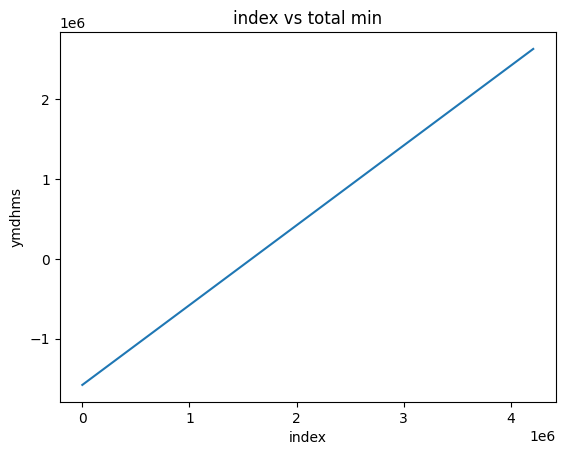

In [203]:
plt.plot(lev3['index'], lev3['total_minutes'])
plt.xlabel('index')
plt.ylabel('ymdhms')
plt.title('index vs total min')
plt.show()

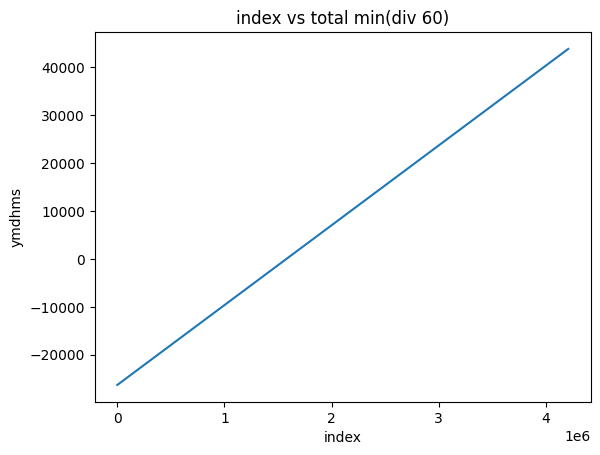

In [204]:
plt.plot(lev3['index'], lev3['total_minutes_sec'])
plt.xlabel('index')
plt.ylabel('ymdhms')
plt.title('index vs total min(div 60)')
plt.show()

In [205]:
#rotation
#drift

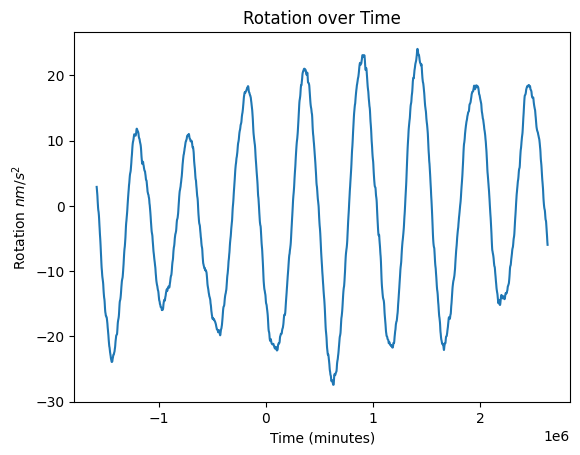

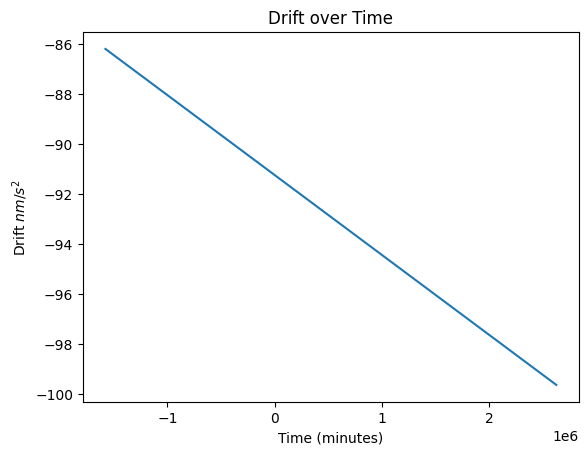

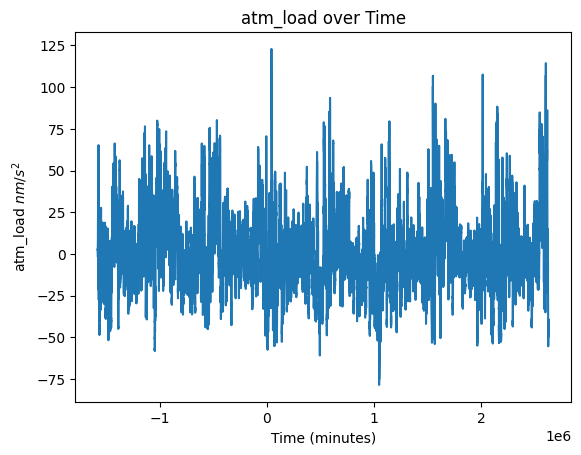

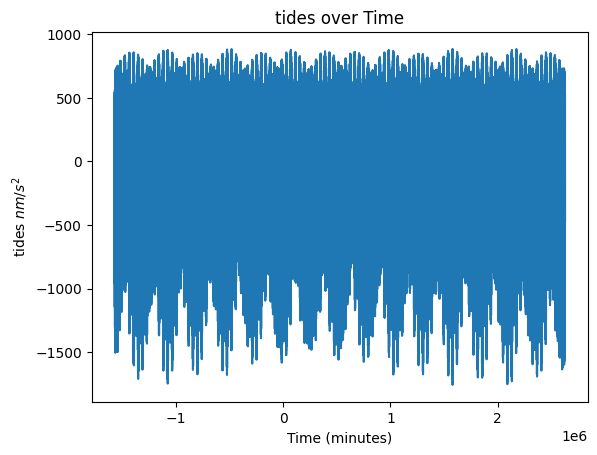

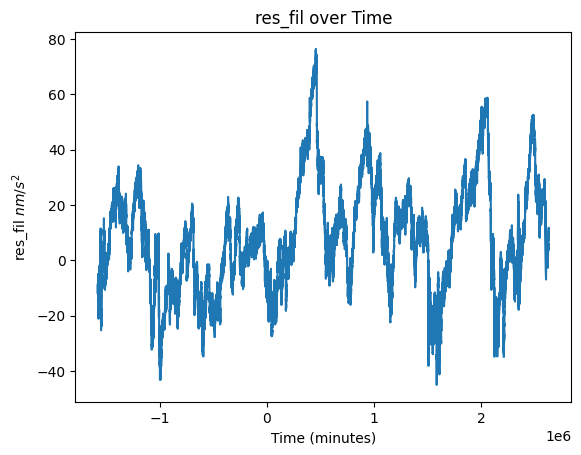

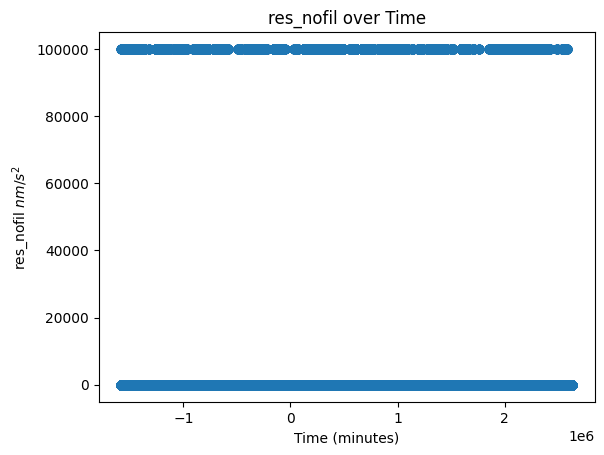

In [206]:
#rotation over time
plt.plot(lev3['total_minutes'], lev3['rotation'])
plt.xlabel('Time (minutes)')
plt.ylabel('Rotation $nm/s^{2}$')
plt.title('Rotation over Time')
plt.show()

#drift over time
plt.plot(lev3['total_minutes'], lev3['drift'])
plt.xlabel('Time (minutes)')
plt.ylabel('Drift $nm/s^{2}$')
plt.title('Drift over Time')
plt.show()

#atm_load over time
plt.plot(lev3['total_minutes'], lev3['atm_load'])
plt.xlabel('Time (minutes)')
plt.ylabel('atm_load $nm/s^{2}$')
plt.title('atm_load over Time')
plt.show()

#tides_load over time
plt.plot(lev3['total_minutes'], lev3['tides'])
plt.xlabel('Time (minutes)')
plt.ylabel('tides $nm/s^{2}$' )
plt.title('tides over Time')
plt.show()

#res over time
plt.plot(lev3['total_minutes'], lev3['res_fil'])
plt.xlabel('Time (minutes)')
plt.ylabel('res_fil $nm/s^{2}$')
plt.title('res_fil over Time')

plt.show()#res over time
plt.scatter(lev3['total_minutes'], lev3['res_nofil'])
plt.xlabel('Time (minutes)')
plt.ylabel('res_nofil $nm/s^{2}$')
plt.title('res_nofil over Time')
plt.show()

In [207]:
max_value = lev3['res_nofil'].max()

print(max_value)

99999.999


In [208]:
inde=lev3['total_minutes']
rota= lev3['rotation']
drif=lev3['drift']

In [209]:
from decimal import Decimal, getcontext

Fitting Equation: y = -5.3217366835061483406146311259110603941735462285578250885009765625E-8x + -91.24


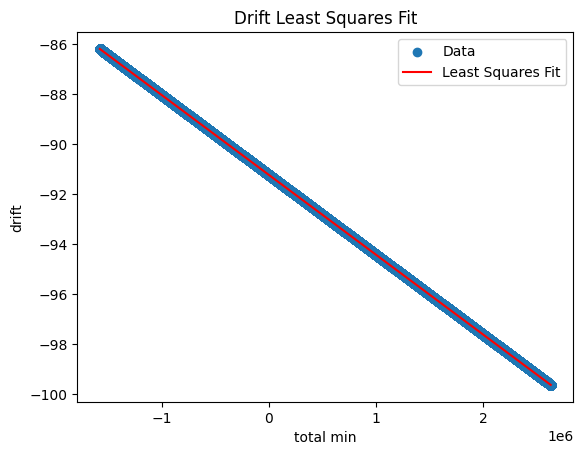

In [210]:
coefficients = np.polyfit(inde, drif, 1)

line = np.polyval(coefficients, inde)

slope = coefficients[0]
intercept = coefficients[1]

getcontext().prec = 4

if slope != 0:
    slope_str = str(Decimal(slope / 60))

print(f"Fitting Equation: y = {slope_str}x + {intercept:.2f}")

plt.scatter(inde, drif, label='Data')
plt.plot(inde, line, color='red', label='Least Squares Fit')
plt.xlabel('total min')
plt.ylabel('drift')
plt.title('Drift Least Squares Fit')
plt.legend()
plt.show()

In [211]:
###############################################################################################################################
#LOOOK HEREEEEEEEEEEEEE
#make the psd here larry
#nah
#kekw

In [212]:
#######
#making the psd

In [213]:
debil = lev3['res_fil']#change the column name and run again, everything would print out
column_name = debil.name

In [214]:
numBins = round(math.sqrt(len(debil)))

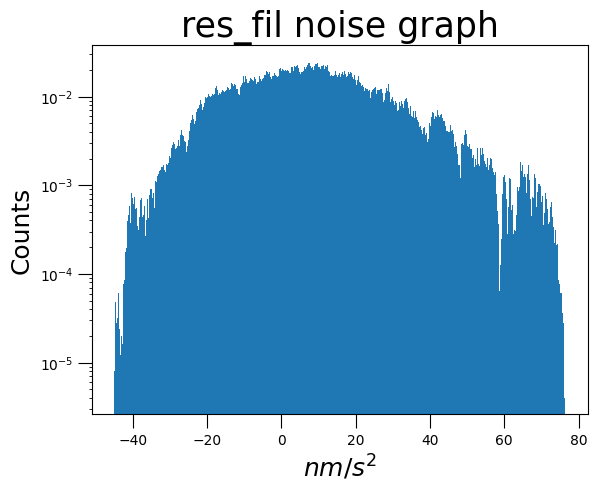

In [215]:
## Histogram
fig, ax = plt.subplots()
ax.hist(debil,bins=numBins,density = True, log = True)          #plots the histogram, bins = sqrt(n)
ax.set_xlabel("$nm/s^{2}$", size = 18)
ax.set_ylabel("Counts", size = 18)
#ax.set_ylim(10e-4, 10e2)
ax.set_title(f"{column_name} noise graph", size=25)
ax.tick_params(axis='both', size=10)

In [216]:
#making the PSD for level 1
#I look at what abby have done, i think i have copied it correctly
N = len(debil)  # number of measurements
samplingRate = 1/60  # once per min sampling rate

# compute the PSD
PSDV = np.abs(np.fft.rfft(debil))**2 / (N*samplingRate)
# PSDV = np.abs(np.fft.rfft(lev1['gravity(V)']))**2 / N
PSDG = (np.abs(rfft(debil))**2)*2/(N*samplingRate)
freq = np.fft.rfftfreq(N, d=1/samplingRate)
N



4207584

In [220]:
debil_h = debil * np.hanning(N)
FAS = np.abs(np.fft.rfft(debil_h))
FAS



array([2.15439403e+07, 1.92702244e+07, 1.34107001e+07, ...,
       6.74262603e+00, 8.93917805e+00, 9.08627573e+00])

Text(0, 0.5, 'Fourier Amplitude Spectrum $pm/s^{2}$')

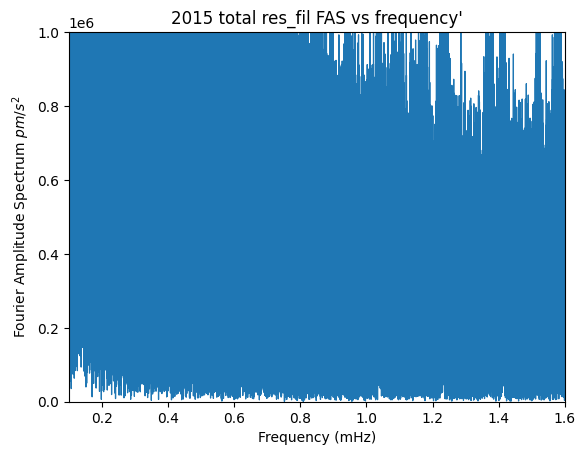

In [218]:
fig, ax = plt.subplots()
ax.plot(freq*1e3, FAS*1e3, linewidth=0.9)
ax.set_title(f"2015 total {column_name} FAS vs frequency'")

ax.set_xlim(0.1, 1.6)

ax.set_ylim(0, 1e6)
ax.set_xlabel('Frequency (mHz)')
ax.set_ylabel('Fourier Amplitude Spectrum $pm/s^{2}$')

Text(0, 0.5, 'Fourier Amplitude Spectrum $pm/s^{2}$')

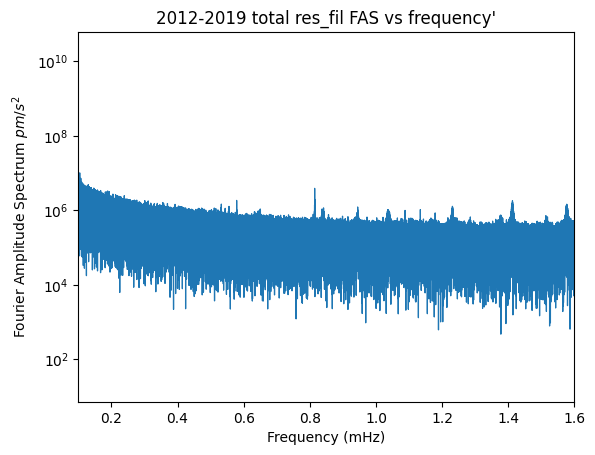

In [221]:


fig, ax = plt.subplots()
ax.plot(freq*1e3, FAS*1e3, linewidth=0.9)
ax.set_title(f"2012-2019 total {column_name} FAS vs frequency'")

ax.set_xlim(0.1, 1.6)


ax.set_xlabel('Frequency (mHz)')
ax.set_ylabel('Fourier Amplitude Spectrum $pm/s^{2}$')